<a href="https://colab.research.google.com/github/este7734/in_domain_transfer_learning/blob/master/model_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Dependencies

In [1]:
import tensorflow as tf
import matplotlib.pylab as plt

import tensorflow_hub as hub
#import tensorflow_datasets as tfds

from tensorflow.keras import layers
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

# To parse file names for tensor generations
# and help count files in each directory
import glob
# To move files into new folder structure
import shutil
# For manipulating file paths
import os

# To add colored text to your print outs
from termcolor import colored

# To get python version number that you're running
from platform import python_version

# To save the final model with a time stamp
import time

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
# Mount Google Drive to save trained models to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Query System Specs

---



In [ ]:
#@title Retrieve Hardware, OS, and Software Specs

print("\n--------Software---------")
print('Python', python_version())
print("\n--------Libraries---------")
print('TensorFlow' , tf.__version__)
print('TensorFlow Hub' , hub.__version__)
# print('Keras v' , layers.__version__)
#print('Glob', glob.__version__)
#print('Shutil', shutil.__version__)
print('matplotlib.pylab', plt.__version__)
print('Numpy', np.__version__)
print('PIL', PIL.__version__)

print("\n--------Operating System------------------------")
!cat /etc/os-release
print("\n--------CPU Specs------------------------")
!lscpu

print("\n--------GPU Specs------------------------")
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('\nYour runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


## Copy data sets from Google Drive to the local instance
Need to Import PyDrive to authorize Colab to your Google Drive Folder

---


*PyDrive is a wrapper library of google-api-python-client that simplifies many common Google Drive API tasks. For this exercise, this allows you to authorize (allows Google Cloud SDK to edit/modify files in your Google Drive) COLAB to access your Google Drive and makes some common tasks such as content fetching very easy.*

Note: This The solution utilizes Google Drive API (official doc) for proper authorization.


---


**Steps:**
1.   Save your `image data zip file` to Google Drive - you should have that since you're already using Colab
2.   Right click on it, "Get shareable link", copy the part between `/d/` and `/view?...` - the file id assigned by Google Drive.
    *   In this example: `https://drive.google.com/file/d/1U3owkzT6AvLewTaOWfgwV__BXHDxehDS/view?usp=sharing` 
    *   your file ID is: `1U3owkzT6AvLewTaOWfgwV__BXHDxehDS`

3.   Navigate to the training data link: and download the training data to the local instance
4.   Add and run the following code snippets to your Colab notebook:

---







In [3]:
# Import package to use Google SDK API - not installed in Colab VM by default
from pydrive.auth import GoogleAuth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
# Other necessary packages
from google.colab import auth
from oauth2client.client import GoogleCredentials
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
# Follow prompt to authorize SDK access to your Google Drive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Load Training Data

In [5]:
# load training data set to your local intance by pulling it from your Google Drive
# to get your file ID from the shareable link in Google Drive, see notes above

#file_id =  '1QUX8zZmCOFTH5X2cZX6sHs1gJJi-OfsX'  
#file_name = 'storage_tank_vs_helo.zip'  # Change this to your file

#file_id =  '1G064PUIaElOpoDQQ_H0ta24tyIVKndbE'  
#file_name = 'Combine_tunnel.zip'  # Change this to your file  

#file_id =  '1Pg-mK7AY3dATEgfpFcFNXHS9uPus6m9o'  
#file_name = 'Combine_storage_tank.zip'  # Change this to your file  

file_id =  '1gz54DDhTUH0fGbSgU3v5BGdFkz3-dzro'  
file_name = 'Combine_oil_gas_fac.zip'  # Change this to your file       

#file_id =  '1o2QB2ylUzzI0k_BdUzr3k_emE3vCl_RI'  
#file_name = 'Combined_helo.zip'  # Change this to your file                               
                                                    
your_file = drive.CreateFile({"id": file_id})
your_file.GetContentFile(file_name)          # Save the file to Colab VM

# Unzip Training, Validation, and Test files
!unzip {file_name}
print(f'\n---- {file_name} unzipped ----\n')
#Verify that all the necessary python files and training data files are in your local instance
%ls

Streaming output truncated to the last 5000 lines.
  inflating: Combine_oil_gas_fac/train/tg_non_tgt/c_t_0000728_2_rgb.jpg  
  inflating: Combine_oil_gas_fac/train/tg_non_tgt/c_t_0003314_7_rgb.jpg  
  inflating: Combine_oil_gas_fac/train/tg_non_tgt/c_t_0007614_2_rgb.jpg  
  inflating: Combine_oil_gas_fac/train/tg_non_tgt/c_t_0000837_0_rgb.jpg  
  inflating: Combine_oil_gas_fac/train/tg_non_tgt/c_t_0010008_1_rgb.jpg  
  inflating: Combine_oil_gas_fac/train/tg_non_tgt/c_t_0000823_0_rgb.jpg  
  inflating: Combine_oil_gas_fac/train/tg_non_tgt/c_t_0010536_1_rgb.jpg  
  inflating: Combine_oil_gas_fac/train/tg_non_tgt/c_t_0005605_2_rgb.jpg  
  inflating: Combine_oil_gas_fac/train/tg_non_tgt/c_t_0000110_1_rgb.jpg  
  inflating: Combine_oil_gas_fac/train/tg_non_tgt/c_t_0009031_1_rgb.jpg  
  inflating: Combine_oil_gas_fac/train/tg_non_tgt/c_t_0007506_1_rgb.jpg  
  inflating: Combine_oil_gas_fac/train/tg_non_tgt/c_t_0009016_9_rgb.jpg  
  inflating: Combine_oil_gas_fac/train/tg_non_tgt/c_t_0002609

##<font color="cyan"> Establish Data Pipeline </font>


---



Got this from Medium article:
https://towardsdatascience.com/tf-data-creating-data-input-pipelines-2913461078e2

Stanford Tutorial:
https://cs230.stanford.edu/blog/datapipeline/#building-an-image-data-pipeline

---




In [8]:
# Set image rescaling factor on training and validation data using ImageDataGenerator
# ImageDataGenerator generates image batches in the form of tensors
# You need your image data in tensors to run the .fit_generator method (to train the model) 
# this is without data augmentation

train_datagen = ImageDataGenerator( 
        rescale=1./255)

val_datagen = ImageDataGenerator( 
        rescale=1./255)

Using TensorFlow backend.


In [13]:
# Instantiate training and validation file paths
base = '/content'

train_path = os.path.join(base, file_name.split('.')[0] + '/train')
val_path = os.path.join(base, file_name.split('.')[0] + '/val')

# Generate list of images files and count them
# Image totals are used in setting steps per epoch
train_files = glob.glob(train_path + '/*/*.jpg')
train_image_count = len(train_files)
print(f'Total training images: {train_image_count}')

val_files = glob.glob(val_path + '/*/*.jpg')
val_image_count = len(val_files)
print(f'Total validation images: {val_image_count}')

Total training images: 9948
Total validation images: 2487


In [14]:
IMG_RES = 224
BATCH_SIZE = 32

print('Training Set:')
train_set = train_datagen.flow_from_directory(
         train_path,
         shuffle=True,
         target_size=(IMG_RES,IMG_RES),
         batch_size=BATCH_SIZE,
         class_mode='binary')  
         #class_mode='categorical') 

classes = train_set.class_indices # captures class indicies in a dictionary. For example: {'non_tgt': 0, 'oil_or_gas_fac': 1}

print('Validation Set:')
val_set = val_datagen.flow_from_directory(
         val_path,
         target_size=(IMG_RES,IMG_RES),
         batch_size=BATCH_SIZE,
         class_mode='binary')   
         #class_mode='categorical')        

Training Set:
Found 9948 images belonging to 2 classes.
Validation Set:
Found 2487 images belonging to 2 classes.


## Plot Sample Images to verify status of Data Pipeline

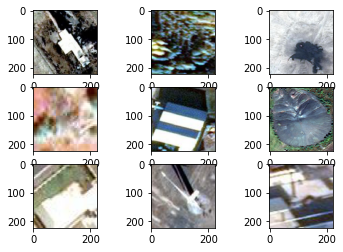

In [15]:
# create a grid of 3*3 images to visualize some of the imgaes in dataset
for i in range(0, 9):
    plt.subplot(330 + 1+ i)
    img = train_set[0][0][i]
    plt.imshow(img)
    
# show the plot
plt.show()

In [16]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
#@title Use this only for agumentation
# Use this to generate sample images to check agumentation (only if you're using image augmentation)

augmented_images = [train_set[0][0][0] for i in range(5)]
plotImages(augmented_images)

# <font color='lightblue'> EuroSat Feature Extractor </font>

Pull in Feature Extractor from TensorFlow Hub

In [21]:
URL = "https://tfhub.dev/google/remote_sensing/uc_merced-resnet50/1"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMG_RES, IMG_RES,3))

# Freeze Variables in feature extractor layer so that only training 
# only modifies the final classification layer.
feature_extractor.trainable = False

### <font color='orange'> Double Object Training - Binary Classifier </font>





Attach Classification Head
Source: l06c01_tensorflow_hub_and_transfer_learning (2 x Classes: cats|dogs)

https://colab.research.google.com/drive/1hPyFkWXN6hd_DIjG83b2Vfxfwua9Imho#scrollTo=mGcY27fY1q3Q

<font color='skyblue'> **SparseCategoricalCrossentropy** </font>

---


In [ ]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax') ### added Softmax activation here in attempt get usable outputs for prediction below
  #layers.Dense(2) 
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23588821  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,592,919
Trainable params: 4,098
Non-trainable params: 23,588,821
_________________________________________________________________


Compile the Model


In [ ]:
model.compile(
  optimizer='adam',
  #loss='categorical_crossentropy',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
  metrics=['accuracy'])

Train the Model


In [ ]:
# Run training session on the model

EPOCHS = 30

history = model.fit_generator(
          train_set, 
          steps_per_epoch=int(np.ceil(train_image_count / float(BATCH_SIZE))),
          epochs=EPOCHS,
          validation_data=val_set,
          validation_steps=int(np.ceil(val_image_count / float(BATCH_SIZE)))
)         

Epoch 1/30
286/286 [==============================] - 21s 72ms/step - loss: 0.4343 - accuracy: 0.8783 - val_loss: 0.4092 - val_accuracy: 0.9063
Epoch 2/30
286/286 [==============================] - 20s 69ms/step - loss: 0.3974 - accuracy: 0.9177 - val_loss: 0.3952 - val_accuracy: 0.9137
Epoch 3/30
286/286 [==============================] - 20s 69ms/step - loss: 0.3880 - accuracy: 0.9250 - val_loss: 0.3923 - val_accuracy: 0.9172
Epoch 4/30
286/286 [==============================] - 20s 70ms/step - loss: 0.3832 - accuracy: 0.9305 - val_loss: 0.3836 - val_accuracy: 0.9308
Epoch 5/30
286/286 [==============================] - 20s 70ms/step - loss: 0.3791 - accuracy: 0.9364 - val_loss: 0.3807 - val_accuracy: 0.9339
Epoch 6/30
286/286 [==============================] - 20s 70ms/step - loss: 0.3749 - accuracy: 0.9405 - val_loss: 0.3817 - val_accuracy: 0.9304
Epoch 7/30
286/286 [==============================] - 20s 70ms/step - loss: 0.3718 - accuracy: 0.9434 - val_loss: 0.3785 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


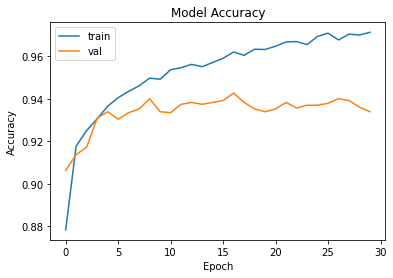

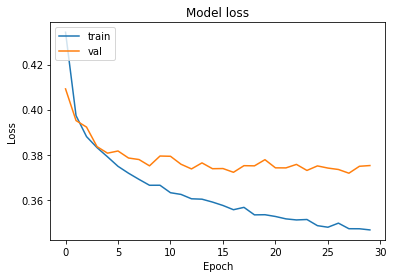

In [ ]:
# Plotting the Loss and Classification Accuracy
model.metrics_names
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Save Trained Model

---




Save as Keras `.h5` model

Now that we've trained the model,  we can save it as an HDF5 file, which is the format used by Keras. Our HDF5 file will have the extension '.h5', and it's name will correspond to the current time stamp.

In [ ]:
#@title Save Model

t = time.time()
model_name = input('Enter model name: ')
# Extract name of original dataset from the training file path 
# to use in naming the saved model
model_path = train_path.split('/')[-2]

# Export the trained model and save it to local instance
export_path_keras = f'{int(t)}_{model_path}_{model_name}_h5_model_.h5'
#export_path_keras = "{}_h5_model{}_{}.h5".format(model_name, int(t), model_path) 
print(f'Model saved to local instance here: {export_path_keras}')
# Save model
model.save(export_path_keras)

# Export the trained model and save it to Google Drive
google_drive_path = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/' 
export_path_keras = f'{google_drive_path}{int(t)}_{model_path}{model_name}_h5_model.h5'
print(f'Model saved to Google Drive here: {export_path_keras}')
# Save model
model.save(export_path_keras)
print(f'Model saved here: {export_path_keras}')

!ls

Enter model name: _30_epochs
Model saved to local instance here: 1594141019_storage_tank_vs_helo__30_epochs_h5_model_.h5
Model saved to Google Drive here: /content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594141019_storage_tank_vs_helo_30_epochs_h5_model.h5
Model saved here: /content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594141019_storage_tank_vs_helo_30_epochs_h5_model.h5
1594141019_storage_tank_vs_helo__30_epochs_h5_model_.h5
adc.json
drive
__MACOSX
sample_data
storage_tank_vs_helo
storage_tank_vs_helo_test
storage_tank_vs_helo_test.zip
storage_tank_vs_helo.zip


In [ ]:
reloaded = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23588821  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,592,919
Trainable params: 4,098
Non-trainable params: 23,588,821
_________________________________________________________________
